IPython magic command to render matplotlib plots.

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### MERFISH whole brain spatial transcriptomics 

The MERFISH data consists of 59 coronal sections (10 micron thick) covering the whole anterior to posterior extent of the brain (~200 micron apart) from a single adult male mouse. Each section is assayed using the MERSCOPE platform with a 500 gene panel designed to enable us to map cells to the whole mouse brain taxonomy.

The MERSCOPE platform uses combinatorial labeling, sequential imaging and error robust barcodes to obtain quantitative (counts) RNA-expression of 100s-1000s of genes. Each probe binds to a specific transcripts resulting in “dots” in the image. Cells are segmented using CellPose software based on DAPI/PolyT stains.

Gene expression data is stored either as individual sections or all sections in a single file. The puprose of this set of notebooks is to provide and overview of the data, the file organization and how to combine the data and metadata through example use cases.

You need to be connected to the internet to run this notebook and have run through the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html).

In [8]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageColor


from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [9]:
download_base = r'/Users/marinag/Documents/Data/abc_atlas'
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20240831/manifest.json'

In [10]:
abc_cache.list_directories

['Allen-CCF-2020',
 'MERFISH-C57BL6J-638850',
 'MERFISH-C57BL6J-638850-CCF',
 'MERFISH-C57BL6J-638850-imputed',
 'MERFISH-C57BL6J-638850-sections',
 'WHB-10Xv3',
 'WHB-taxonomy',
 'WMB-10X',
 'WMB-10XMulti',
 'WMB-10Xv2',
 'WMB-10Xv3',
 'WMB-neighborhoods',
 'WMB-taxonomy',
 'Zhuang-ABCA-1',
 'Zhuang-ABCA-1-CCF',
 'Zhuang-ABCA-2',
 'Zhuang-ABCA-2-CCF',
 'Zhuang-ABCA-3',
 'Zhuang-ABCA-3-CCF',
 'Zhuang-ABCA-4',
 'Zhuang-ABCA-4-CCF']

## Data overview

### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*.

Each cell is associated with a *brain section label*, *donor label*, *donor genotype* and *donor sex*. Each cell also has a set of x, y, z coordinates generated by rotating each section so that it is upright with midline approximatedly in the middle of the frame. The z coordinate takes into account the phyiscal spacing between each section.

Each cell is mapped to the whole mouse brain taxonomy using a hierachical correlation method, resulting in the assignment of a *cluster alias" and *average correlation score*.

#### Get metadata for MERFISH brain

In [11]:
# Check what files are available
abc_cache.list_metadata_files(directory='MERFISH-C57BL6J-638850')

['cell_metadata',
 'cell_metadata_with_cluster_annotation',
 'example_genes_all_cells_expression',
 'gene']

In [12]:
# Get cell metadata with cell type annotations
cell_metadata_clusters = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='cell_metadata_with_cluster_annotation')
cell_metadata_clusters.head()

,cell_label,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,...,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
0,1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,...,NaN,04 DG-IMN Glut,038 DG-PIR Ex IMN,0141 DG-PIR Ex IMN_2,0515 DG-PIR Ex IMN_2,#666666,#16f2f2,#3D53CC,#CC7A3D,#73FFBF
1,1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,...,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
2,1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,...,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
3,1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,...,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
4,1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,...,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63


In [13]:
# Gete gene names
genes = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='gene')
genes.head()

,gene_identifier,gene_symbol,transcript_identifier,name,mapped_ncbi_identifier
0,ENSMUSG00000026778,Prkcq,ENSMUST00000028118,"protein kinase C, theta",NCBIGene:18761
1,ENSMUSG00000026837,Col5a1,ENSMUST00000028280,"collagen, type V, alpha 1",NCBIGene:12831
2,ENSMUSG00000001985,Grik3,ENSMUST00000030676,"glutamate receptor, ionotropic, kainate 3",NCBIGene:14807
3,ENSMUSG00000039323,Igfbp2,ENSMUST00000047328,insulin-like growth factor binding protein 2,NCBIGene:16008
4,ENSMUSG00000048387,Osr1,ENSMUST00000057021,odd-skipped related transcription factor 1,NCBIGene:23967


#### Get metadata for MERFISH-CCF

In [14]:
# Check what is available in the merfish-ccf directory
abc_cache.list_metadata_files(directory='MERFISH-C57BL6J-638850-CCF')

['ccf_coordinates',
 'cell_metadata_with_parcellation_annotation',
 'reconstructed_coordinates']

In [15]:
# Get cell metadata with brain area annotations
ccf_annotated_metadata = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850-CCF', file_name='cell_metadata_with_parcellation_annotation')
ccf_annotated_metadata.head()

,cell_label,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
0,1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,...,brain,grey,HPF,DG,DG-po,#FFFFFF,#BFDAE3,#7ED04B,#7ED04B,#7ED04B
1,1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,...,brain,grey,P,TRN,TRN,#FFFFFF,#BFDAE3,#FF9B88,#FFBA86,#FFBA86
2,1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88
3,1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,...,brain,fiber tracts,cbf,arb,arb,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
4,1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88


In [16]:
ccf_annotated_metadata.columns

Index(['cell_label', 'brain_section_label', 'cluster_alias',
       'average_correlation_score', 'feature_matrix_label', 'donor_label',
       'donor_genotype', 'donor_sex', 'x_section', 'y_section', 'z_section',
       'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster',
       'neurotransmitter_color', 'class_color', 'subclass_color',
       'supertype_color', 'cluster_color', 'x_reconstructed',
       'y_reconstructed', 'z_reconstructed', 'parcellation_index', 'x_ccf',
       'y_ccf', 'z_ccf', 'parcellation_organ', 'parcellation_category',
       'parcellation_division', 'parcellation_structure',
       'parcellation_substructure', 'parcellation_organ_color',
       'parcellation_category_color', 'parcellation_division_color',
       'parcellation_structure_color', 'parcellation_substructure_color'],
      dtype='object')

In [17]:
# This df has both cell type annotations and ccf annotations, we can use this as our main metadata dataframe
cell_metadata = ccf_annotated_metadata.copy()

#### Get expression data


In [18]:
abc_cache.list_data_files('MERFISH-C57BL6J-638850')

['C57BL6J-638850/log2', 'C57BL6J-638850/raw']

In [19]:
# Use log2 normalized expression data - first get file location
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850', file_name='C57BL6J-638850/log2')
print(file)

/Users/marinag/Documents/Data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad


In [20]:
# Load log2 normalized expression data using anndata package
data = anndata.read_h5ad(file, backed='r')
print(data)

AnnData object with n_obs × n_vars = 4334174 × 550 backed at '/Users/marinag/Documents/Data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad'
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'


In [21]:
genes.head()

,gene_identifier,gene_symbol,transcript_identifier,name,mapped_ncbi_identifier
0,ENSMUSG00000026778,Prkcq,ENSMUST00000028118,"protein kinase C, theta",NCBIGene:18761
1,ENSMUSG00000026837,Col5a1,ENSMUST00000028280,"collagen, type V, alpha 1",NCBIGene:12831
2,ENSMUSG00000001985,Grik3,ENSMUST00000030676,"glutamate receptor, ionotropic, kainate 3",NCBIGene:14807
3,ENSMUSG00000039323,Igfbp2,ENSMUST00000047328,insulin-like growth factor binding protein 2,NCBIGene:16008
4,ENSMUSG00000048387,Osr1,ENSMUST00000057021,odd-skipped related transcription factor 1,NCBIGene:23967


In [22]:
print("Number of genes = ", len(data.var))
data.var.index[0:5]

Number of genes =  550


Index(['ENSMUSG00000026778', 'ENSMUSG00000026837', 'ENSMUSG00000001985',
       'ENSMUSG00000039323', 'ENSMUSG00000048387'],
      dtype='object', name='gene_identifier')

It appears that the anndata object contains some of the same data that is in the metadata tables, with gene info, brain section info, etc. 

It should also have the expression data per cell, which is not in the metadata tables

#### Plot subclasses for one section

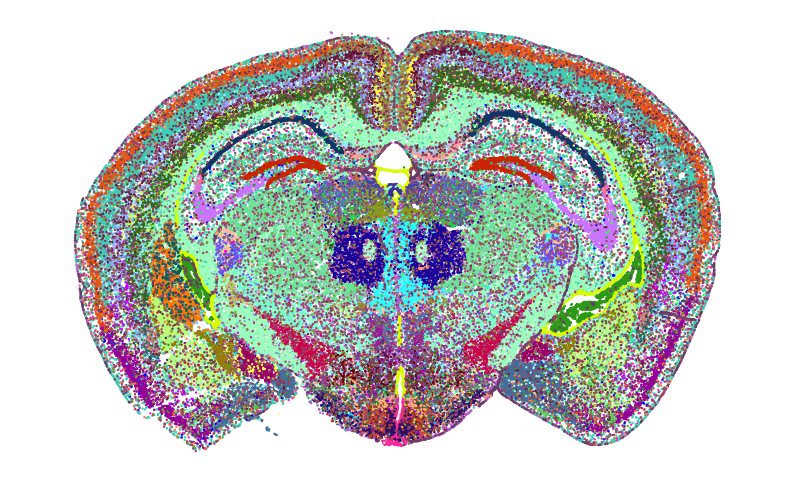

In [23]:
# Get a specific section and its associated metadata
brain_section_labels = np.sort(cell_metadata.brain_section_label.unique())
brain_section_label = brain_section_labels[25]
brain_section_data = cell_metadata[cell_metadata.brain_section_label==brain_section_label]

# Plot cell xy locations and color by subclass
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x=brain_section_data['x_section'].values, y=brain_section_data['y_section'].values, 
           c=brain_section_data['subclass_color'], s=0.5)
# flip and clean axes
ax.set_ylim(11, 0)
ax.set_xlim(0, 11)
ax.axis('equal')
ax.axis('off');

#### Reformat expression data & limit to areas & genes of interest

In [24]:
gene_names = np.sort(genes.gene_symbol.unique())

In [25]:
# Get genes of interest
genes_list = ['Calb1', 'Calb2', 'Cck', 'Crh', 'Chat', 'Chodl', 'Crh', 'Etv1', 'Hpse', 'Kirrel3', 'Lamp5', 
              'Meis2', 'Mybpc1', 'Ndnf', 'Necab1', 'Nos1', 'Npy', 'Oprm1', 'Penk', 'Pthlh', 'Ptprt', 'Pvalb', 'Reln', 'Rspo2', 
              'Slc32a2', 'Sncg', 'Sst', 'Tac1', 'Tac2', 'Vip', 'Vipr2']
print(len(genes_list))
selected_genes = genes[genes.gene_symbol.isin(genes_list)].set_index('gene_identifier')
print(len(selected_genes))

31
15


In [26]:
print(len(genes[genes.gene_identifier=='ENSG00000187094']), 'Cck') # Cck
print(len(genes[genes.gene_identifier=='ENSG00000006468']), 'Etv1') # Etv1
print(len(genes[genes.gene_identifier=='ENSG00000122585']), 'Npy') # Npy
print(len(genes[genes.gene_identifier=='ENSG00000173267']), 'Sncg') # Sncg
print(len(genes[genes.gene_identifier=='ENSG00000006128']), 'Tac1') # Tac1

0 Cck
0 Etv1
0 Npy
0 Sncg
0 Tac1


In [27]:
missing_genes = [gene for gene in genes_list if gene not in gene_names]
missing_genes

['Cck',
 'Etv1',
 'Hpse',
 'Kirrel3',
 'Meis2',
 'Mybpc1',
 'Npy',
 'Oprm1',
 'Pthlh',
 'Ptprt',
 'Slc32a2',
 'Sncg',
 'Sst',
 'Tac1',
 'Vipr2']

In [57]:
# Genes missing from Zhuang dataset
zhuang_missing = ['Cck', 'Kirrel3', 'Nos1', 'Npy', 'Ptprt', 'Slc32a2', 'Sst', 'Tac1', 'Vip']

In [61]:
# Genes in Zhuang but not AIBS
[gene for gene in genes_list if gene not in zhuang_missing and gene not in gene_names]

['Etv1', 'Hpse', 'Meis2', 'Mybpc1', 'Oprm1', 'Pthlh', 'Sncg', 'Vipr2']

Looks like a bunch of our genes are missing from the MERFISH panel! 

In [28]:
# Get expression data for all cells for our selected genes
data_subset = data[:, selected_genes.index].to_memory()
data_subset

AnnData object with n_obs × n_vars = 4334174 × 15
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'

In [29]:
# Limit to cells in visual cortex
visual_cortex_cells = cell_metadata[(cell_metadata.parcellation_structure.str.contains('VIS')) & (cell_metadata.parcellation_structure!='VISC')].set_index('cell_label')
print(len(visual_cortex_cells), 'cells in ', visual_cortex_cells.parcellation_structure.unique())

130144 cells in  ['VISp' 'VISa' 'VISpor' 'VISpl' 'VISl' 'VISli' 'VISrl' 'VISpm' 'VISam'
 'VISal']


In [30]:
visual_cortex_cells.head(2)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171912101090014,C57BL6J-638850.27,1392,0.503378,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.819100,2.950538,4.4,...,brain,grey,Isocortex,VISp,VISp1,#FFFFFF,#BFDAE3,#70FF71,#08858C,#08858C
1017092617100650324,C57BL6J-638850.38,2762,0.707227,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.690907,2.204693,6.8,...,brain,grey,Isocortex,VISa,VISa1,#FFFFFF,#BFDAE3,#70FF71,#009FAC,#009FAC


In [31]:
# Get expression data for selected genes for cells in visual cortex 
selected_cells = visual_cortex_cells.index.values
vis_gene_data = data[selected_cells, selected_genes.index].to_df()
vis_gene_data.columns = selected_genes.gene_symbol
vis_gene_data.head()

gene_symbol,Calb1,Calb2,Nos1,Pvalb,Ndnf,Tac2,Penk,Chodl,Necab1,Lamp5,Crh,Chat,Reln,Rspo2,Vip
cell_label,,,,,,,,,,,,,,,
1019171912101090014,0.000000,0.000000,0.0,0.741697,0.000000,0.0,0.0,0.0,1.229147,0.741697,0.000000,0.0,0.741697,0.000000,2.124562
1017092617100650324,0.000000,1.892214,0.0,0.000000,4.560738,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,5.689993,0.000000,0.000000
1019171910102620041,0.000000,0.878220,0.0,0.000000,4.840840,0.0,0.0,0.0,0.878220,0.000000,0.000000,0.0,2.779625,0.878220,0.000000
1018093344102460798,0.819577,1.720132,0.0,0.000000,4.872872,0.0,0.0,0.0,0.000000,1.720132,0.000000,0.0,4.216644,0.819577,0.819577
1018093344102150014,0.691781,2.957550,0.0,0.000000,3.665648,0.0,0.0,0.0,1.157401,0.691781,0.691781,0.0,4.607655,0.000000,0.691781


#### Join expression data & cell metadata to sort by cell type and plot gene expression

In [32]:
cell_type_metadata_cols = ['neurotransmitter', 'class', 'subclass', 'supertype', 'cluster',]

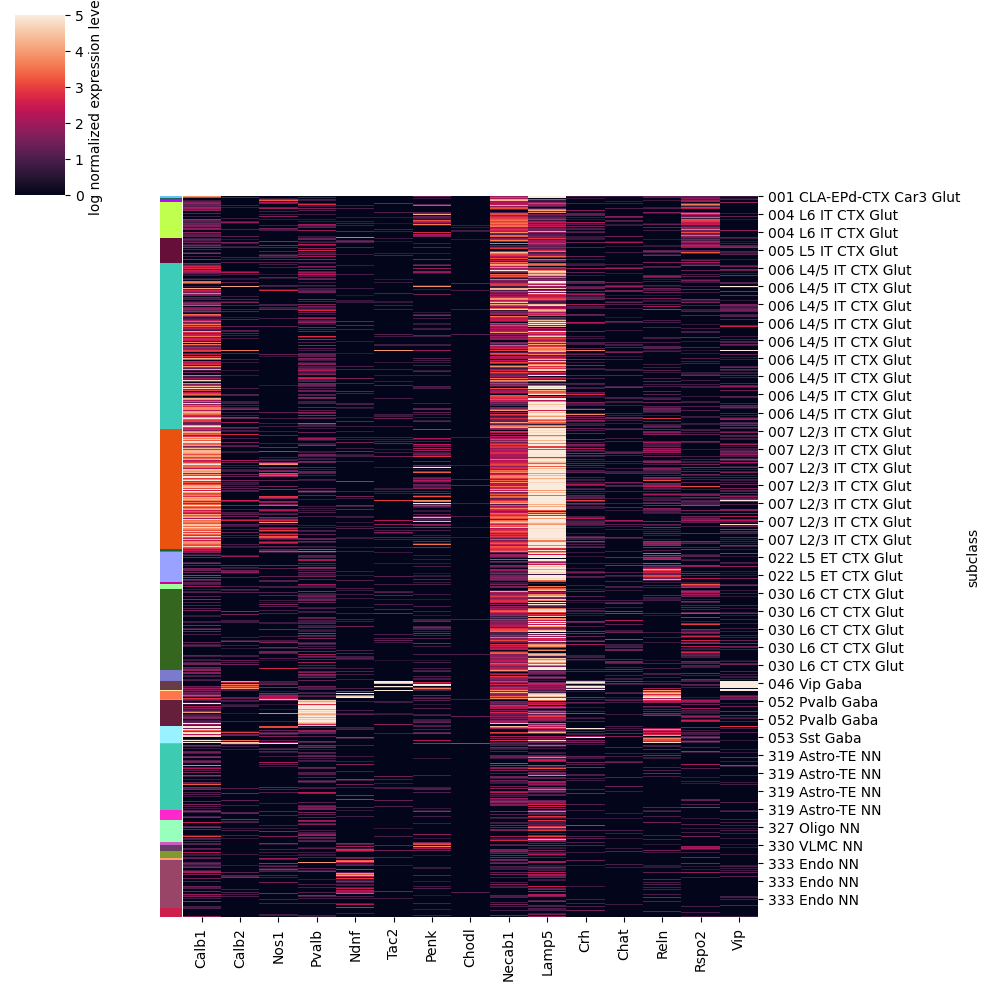

In [33]:
# merge with subclass metadata for cells
data_to_plot = vis_gene_data.join(visual_cortex_cells[['subclass', 'subclass_color']], on='cell_label')
data_to_plot = data_to_plot.sort_values(by='subclass')
data_to_plot = data_to_plot.reset_index(drop=True)
data_to_plot = data_to_plot.set_index(['subclass'])

# plot heatmap sorted by subclass
row_colors = [[c/255 for c in ImageColor.getcolor(color, "RGBA")] for color in data_to_plot.subclass_color.values]
ax = sns.clustermap(data=data_to_plot[selected_genes.gene_symbol], vmax=5, 
                 cbar_kws={'label':'log normalized expression level'}, 
                 row_cluster=False, col_cluster=False, 
                 row_colors=row_colors)

In [34]:
visual_cortex_cells['neurotransmitter'].unique()

array(['Dopa', 'Glut', 'GABA', nan, 'Glut-GABA'], dtype=object)

In [35]:
# How many cells are both Glut and GABA
len(visual_cortex_cells[visual_cortex_cells.neurotransmitter=='Glut-GABA'])

21

In [36]:
# How many cells are GABA only
len(visual_cortex_cells[visual_cortex_cells.neurotransmitter=='GABA'])

11298

In [37]:
# Limit to gabaergic cells
inh_gene_data = vis_gene_data.loc[visual_cortex_cells[visual_cortex_cells.neurotransmitter=='GABA'].index.values]
print(len(inh_gene_data))
inh_gene_data.head()

11298


gene_symbol,Calb1,Calb2,Nos1,Pvalb,Ndnf,Tac2,Penk,Chodl,Necab1,Lamp5,Crh,Chat,Reln,Rspo2,Vip
cell_label,,,,,,,,,,,,,,,
1019171907100350770,0.000000,1.901055,1.901055,1.497353,0.000000,0.000000,3.875221,0.000000,0.000000,2.216139,0.000000,0.000000,0.0,0.934796,0.000000
1104095349102660266,1.360933,0.835323,4.060490,5.212405,0.835323,0.000000,0.835323,0.000000,0.000000,2.048593,0.000000,0.000000,0.0,0.000000,0.000000
1018093344102360208-1,0.000000,1.739359,1.739359,0.000000,0.000000,0.000000,3.199442,1.117318,1.739359,1.117318,0.000000,0.000000,0.0,0.000000,0.000000
1019171910102330296,0.915184,1.470729,1.470729,0.915184,0.000000,0.000000,3.744304,0.000000,2.183721,1.870830,0.000000,0.000000,0.0,0.000000,0.915184
1104095349103000103,0.000000,5.337257,0.000000,0.838787,0.000000,4.528526,3.681245,0.000000,1.365744,0.000000,2.869549,0.838787,0.0,0.000000,4.713336


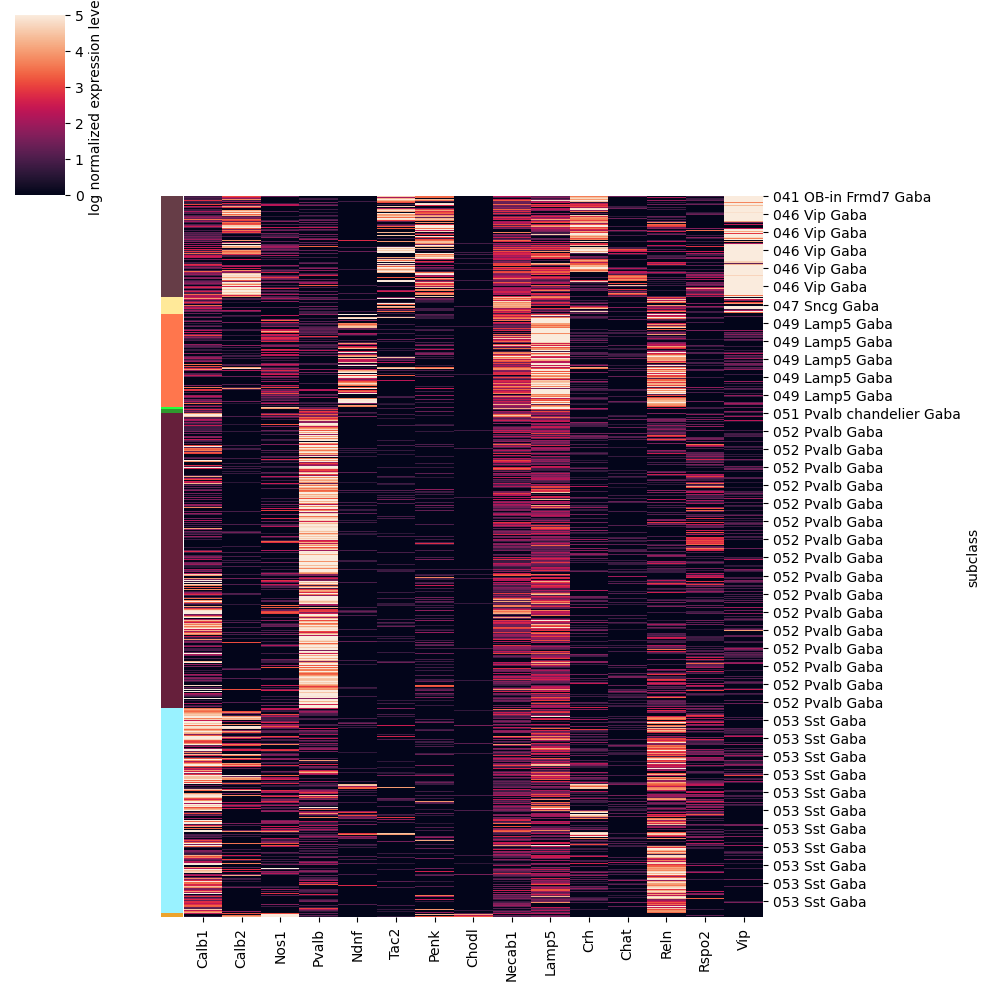

In [38]:
# Limit to inhibitory cells within visual cortex and plot
inh_gene_data = vis_gene_data.loc[visual_cortex_cells[visual_cortex_cells.neurotransmitter=='GABA'].index.values]

# merge with subclass metadata for cells
data_to_plot = inh_gene_data.join(visual_cortex_cells[['subclass', 'subclass_color']], on='cell_label', how='left')
data_to_plot = data_to_plot.sort_values(by='subclass')
data_to_plot = data_to_plot.reset_index(drop=True)
data_to_plot = data_to_plot.set_index(['subclass'])

# plot heatmap sorted by subclass
row_colors = [[c/255 for c in ImageColor.getcolor(color, "RGBA")] for color in data_to_plot.subclass_color.values]
ax = sns.clustermap(data=data_to_plot[selected_genes.gene_symbol], vmax=5, 
                 cbar_kws={'label':'log normalized expression level'}, 
                 row_cluster=False, col_cluster=False, 
                 row_colors=row_colors)

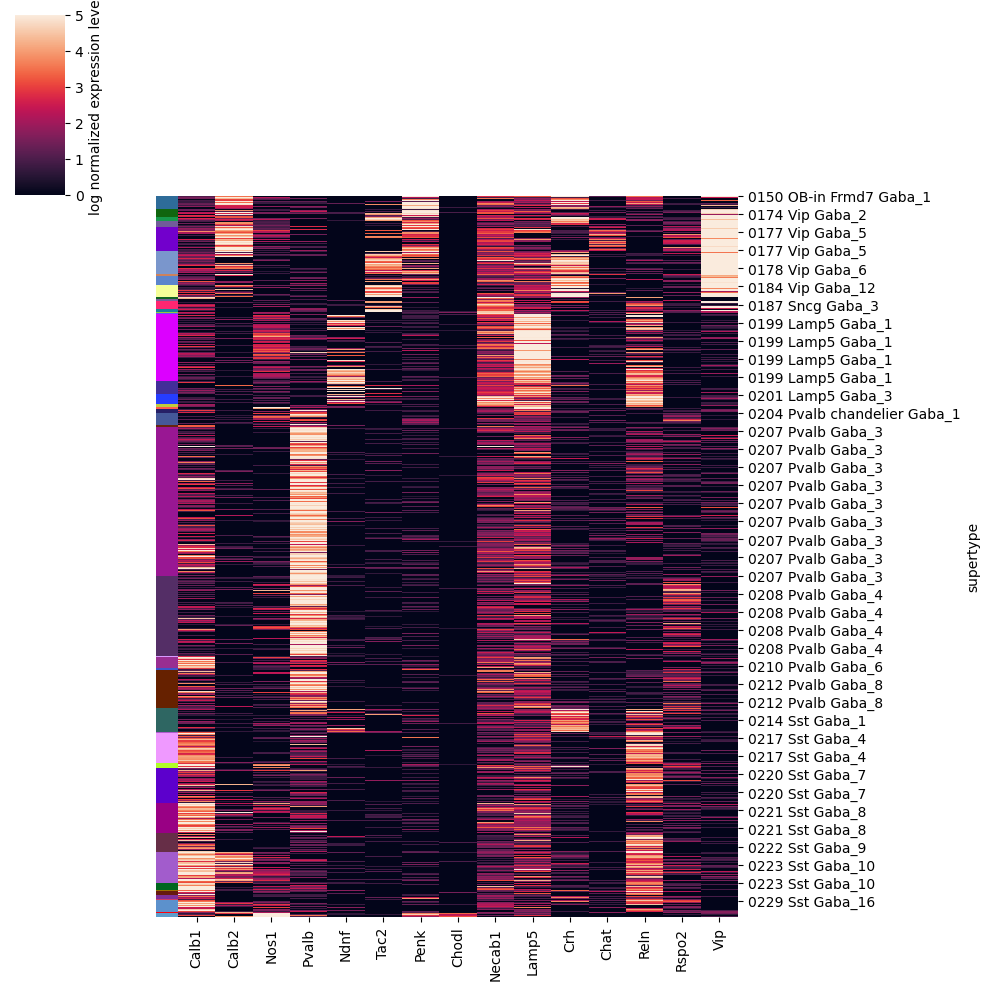

In [39]:
# Plot by supertype 

# Limit to inhibitory cells and plot
inh_gene_data = vis_gene_data.loc[visual_cortex_cells[visual_cortex_cells.neurotransmitter=='GABA'].index.values]

type_col = 'supertype'
color_col = 'supertype_color'

# merge with subclass metadata for cells
data_to_plot = inh_gene_data.join(visual_cortex_cells[[type_col, color_col]], on='cell_label', how='left')
data_to_plot = data_to_plot.sort_values(by=type_col)
data_to_plot = data_to_plot.reset_index(drop=True)
data_to_plot = data_to_plot.set_index([type_col])

# plot heatmap sorted by subclass
row_colors = [[c/255 for c in ImageColor.getcolor(color, "RGBA")] for color in data_to_plot[color_col].values]
ax = sns.clustermap(data=data_to_plot[selected_genes.gene_symbol], vmax=5, 
                 cbar_kws={'label':'log normalized expression level'}, 
                 row_cluster=False, col_cluster=False, 
                 row_colors=row_colors)



In [40]:
# Avg expression per supertype

# Limit to inhibitory cells and plot
inh_gene_data = vis_gene_data.loc[visual_cortex_cells[visual_cortex_cells.neurotransmitter=='GABA'].index.values]

type_col = 'supertype'
color_col = 'supertype_color'

# merge with subclass metadata for cells
data_to_plot = inh_gene_data.join(visual_cortex_cells[[type_col, color_col]], on='cell_label', how='left')
data_to_plot = data_to_plot.sort_values(by=type_col)
data_to_plot = data_to_plot.reset_index(drop=True)
# data_to_plot = data_to_plot.set_index([type_col])

# count n cells per supertype
vis_inh_cells = visual_cortex_cells[visual_cortex_cells.neurotransmitter=='GABA']
n_cells_per_supertype = pd.DataFrame(vis_inh_cells.value_counts(type_col)).reset_index()
# limit to supertypes with > 5 cells
types_to_include = n_cells_per_supertype[n_cells_per_supertype['count']>5][type_col]
data_to_plot = data_to_plot[data_to_plot[type_col].isin(types_to_include)]

# get rid of color column because it messes up the plot
avg_expression = data_to_plot.drop(columns=[color_col]).groupby(type_col).mean()
avg_expression.head()

,Calb1,Calb2,Nos1,Pvalb,Ndnf,Tac2,Penk,Chodl,Necab1,Lamp5,Crh,Chat,Reln,Rspo2,Vip
supertype,,,,,,,,,,,,,,,
0173 Vip Gaba_1,1.087220,3.715503,0.506137,0.567989,0.256007,0.662198,4.515610,0.065949,1.722276,1.780199,3.593205,0.310644,1.788988,0.099747,1.321477
0174 Vip Gaba_2,1.493115,1.969451,0.428284,0.551217,0.158384,1.227257,4.071852,0.077251,1.904735,2.077435,1.134405,0.397804,0.774347,0.833731,5.860994
0175 Vip Gaba_3,1.565569,1.955253,1.116994,0.231847,0.092324,4.199900,1.285050,0.000000,2.399005,1.619673,3.799082,1.359330,0.864878,0.411323,5.611951
0176 Vip Gaba_4,0.754231,2.754035,0.892501,0.744702,0.108151,0.098734,4.004084,0.059751,1.260985,1.466360,2.377176,0.525915,0.323411,1.052588,6.347394
0177 Vip Gaba_5,1.217560,4.446417,1.155396,0.620791,0.077188,0.795021,2.868289,0.033138,1.959347,1.802725,0.600285,2.373178,0.252924,1.625422,6.068277


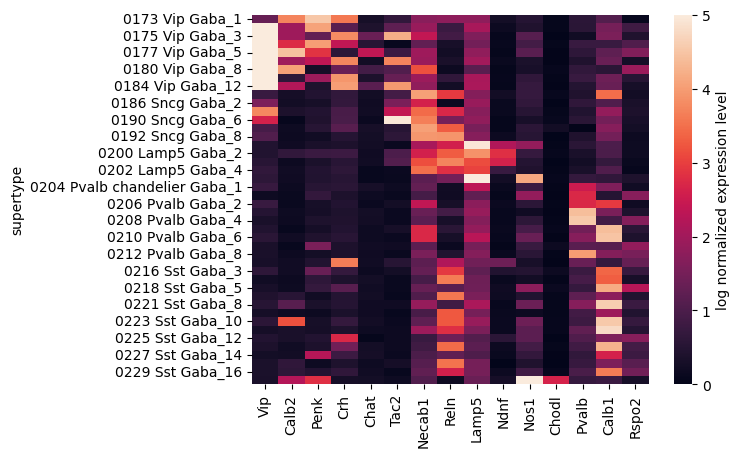

In [41]:
sorted_genes = ['Vip', 'Calb2', 'Penk', 'Crh', 'Chat', 
                'Tac2', 'Necab1', 'Reln', 'Lamp5', 'Ndnf', 'Nos1', 'Chodl',
                'Pvalb', 'Calb1', 'Rspo2']
       
       
fig, ax = plt.subplots()

ax = sns.heatmap(avg_expression[sorted_genes], vmax=5, cbar_kws={'label':'log normalized expression level'}, )


#### Count N cells per supertype

In [42]:
type_col = 'supertype'
# limit to inhibitory cells in visual cortex
vis_inh_cells = visual_cortex_cells[visual_cortex_cells.neurotransmitter=='GABA']
# count n cells per supertype
n_cells_per_supertype = pd.DataFrame(vis_inh_cells.value_counts(type_col)).reset_index()
# limit to supertypes with > 5 cells
types_to_include = n_cells_per_supertype[n_cells_per_supertype['count']>5][type_col]
n_cells_per_supertype = n_cells_per_supertype[n_cells_per_supertype[type_col].isin(types_to_include)]
vis_inh_cells = vis_inh_cells[vis_inh_cells[type_col].isin(types_to_include)]

vis_inh_cells.head()

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
cell_label,,,,,,,,,,,,,,,,,,,,,
1104095349101230031,C57BL6J-638850.26,591,0.548169,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.280105,3.244185,4.2,...,brain,grey,Isocortex,VISp,VISp5,#FFFFFF,#BFDAE3,#70FF71,#08858C,#08858C
1104095349102980133,C57BL6J-638850.32,505,0.576364,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.676493,3.558176,5.6,...,brain,grey,Isocortex,VISp,VISp5,#FFFFFF,#BFDAE3,#70FF71,#08858C,#08858C
1019171912100590305,C57BL6J-638850.27,631,0.602613,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.696662,4.019872,4.4,...,brain,grey,Isocortex,VISli,VISli2/3,#FFFFFF,#BFDAE3,#70FF71,#08858C,#08858C
1018093344101000529-3,C57BL6J-638850.30,704,0.553382,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.442337,3.884550,5.0,...,brain,grey,Isocortex,VISp,VISp6a,#FFFFFF,#BFDAE3,#70FF71,#08858C,#08858C
1017092617101080137,C57BL6J-638850.25,600,0.510457,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.543491,3.588072,4.0,...,brain,grey,Isocortex,VISp,VISp5,#FFFFFF,#BFDAE3,#70FF71,#08858C,#08858C


In [43]:
n_cells_per_supertype

,supertype,count
0,0207 Pvalb Gaba_3,2335
1,0208 Pvalb Gaba_4,1250
2,0199 Lamp5 Gaba_1,1046
3,0212 Pvalb Gaba_8,597
4,0220 Sst Gaba_7,548
5,0223 Sst Gaba_10,495
6,0221 Sst Gaba_8,466
7,0217 Sst Gaba_4,466
8,0178 Vip Gaba_6,369
9,0214 Sst Gaba_1,366


In [44]:
# add colors for supertypes
n_cells_per_supertype[color_col] = [visual_cortex_cells[visual_cortex_cells[type_col]==type_val][color_col].values[0] for type_val in n_cells_per_supertype[type_col].values]

In [45]:
# sort by supertype
n_cells_per_supertype = n_cells_per_supertype.sort_values(by=type_col)

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_37093/1105960140.py:3: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=n_cells_per_supertype, y=type_col, x='count', orient='h',


Text(0.5, 1.0, '# cells per supertype in visual cortex')

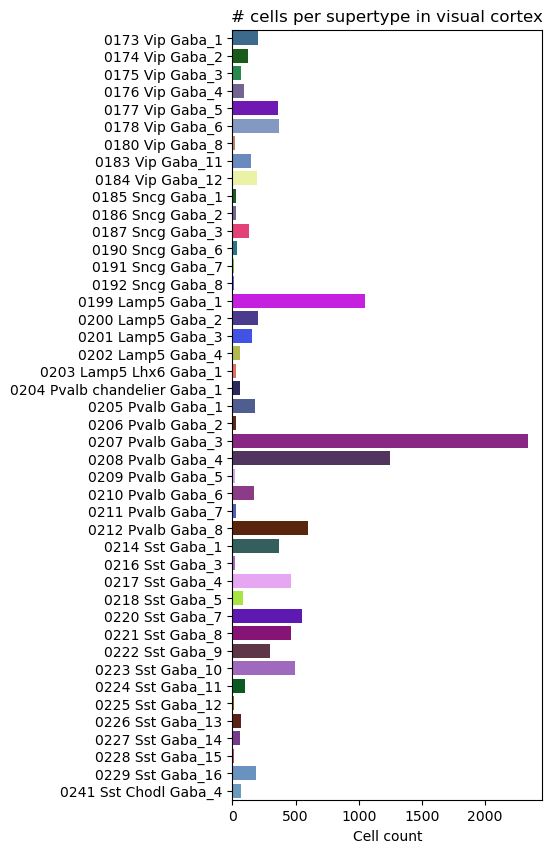

In [46]:
# plot counts
fig, ax = plt.subplots(figsize=(4, 10))
ax = sns.barplot(data=n_cells_per_supertype, y=type_col, x='count', orient='h',
                 hue=type_col, palette=n_cells_per_supertype[color_col].values, 
                 ax=ax)
# ax.get_legend().remove()
ax.set_ylabel('')
ax.set_xlabel('Cell count')
ax.set_title('# cells per supertype in visual cortex')

#### Quantify co-expression

In [47]:
# merge with subclass metadata for cells
data_to_plot = inh_gene_data.join(visual_cortex_cells[[type_col, color_col]], on='cell_label', how='left')
data_to_plot = data_to_plot.sort_values(by=type_col)
data_to_plot = data_to_plot.reset_index(drop=True)
data_to_plot = data_to_plot.set_index([type_col])

(-0.2, 2.0)

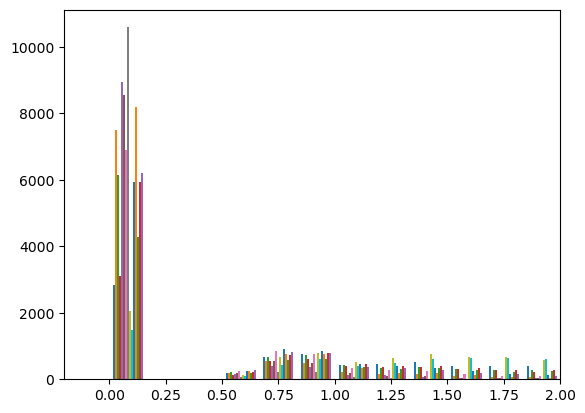

In [48]:
# plot histogram of expression values to see if there is a reasonable threshold to binarize
plt.hist(inh_gene_data[selected_genes.gene_symbol].values, bins=50);
plt.xlim(-0.2, 2)

Binarize and pivot

In [49]:
# Binarize and melt to get yes-no expression state for each gene for each cell
expression_binary = inh_gene_data.copy()
expression_binary[expression_binary>0.5] = 1

expression_binary = expression_binary.reset_index()
expression_binary = expression_binary.melt(id_vars=['cell_label'])
expression_binary.head()

,cell_label,gene_symbol,value
0,1019171907100350770,Calb1,0.0
1,1104095349102660266,Calb1,1.0
2,1018093344102360208-1,Calb1,0.0
3,1019171910102330296,Calb1,1.0
4,1104095349103000103,Calb1,0.0


In [50]:
# Get the metadata back
expression_binary = expression_binary.merge(visual_cortex_cells[['supertype']], on='cell_label', how='left')
expression_binary

,cell_label,gene_symbol,value,supertype
0,1019171907100350770,Calb1,0.0,0150 OB-in Frmd7 Gaba_1
1,1104095349102660266,Calb1,1.0,1149 CBX MLI Megf11 Gaba_1
2,1018093344102360208-1,Calb1,0.0,0150 OB-in Frmd7 Gaba_1
3,1019171910102330296,Calb1,1.0,0151 OB-in Frmd7 Gaba_2
4,1104095349103000103,Calb1,0.0,0161 OB-mi Frmd7 Gaba_1
...,...,...,...,...
169465,1019171907201930205,Vip,1.0,0183 Vip Gaba_11
169466,1019171912100750058,Vip,1.0,0183 Vip Gaba_11
169467,1019171912100910319,Vip,0.0,0229 Sst Gaba_16
169468,1018093344102220566,Vip,1.0,0183 Vip Gaba_11


In [51]:
# Pivot to get matrix of expression state by gene for cells
exp_pivot = pd.pivot_table(data=expression_binary, index=['supertype', 'cell_label'], columns='gene_symbol', values='value', aggfunc=np.nanmean)
exp_pivot

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_37093/147544150.py:2: FutureWarning: The provided callable <function nanmean at 0x7f8bf864dee0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  exp_pivot = pd.pivot_table(data=expression_binary, index=['supertype', 'cell_label'], columns='gene_symbol', values='value', aggfunc=np.nanmean)


gene_symbol                                       Calb1  Calb2  Chat  Chodl  \
supertype                  cell_label                                         
0150 OB-in Frmd7 Gaba_1    1018093344102360208-1    0.0    1.0   0.0    1.0   
                           1019171907100350770      0.0    1.0   0.0    0.0   
0151 OB-in Frmd7 Gaba_2    1019171910102330296      1.0    1.0   0.0    0.0   
0161 OB-mi Frmd7 Gaba_1    1104095349103000103      0.0    1.0   1.0    0.0   
0173 Vip Gaba_1            1017092617100310222      1.0    1.0   0.0    0.0   
...                                                 ...    ...   ...    ...   
0241 Sst Chodl Gaba_4      1104095349102660247-1    0.0    1.0   0.0    1.0   
                           1104095349102660248-1    0.0    1.0   1.0    1.0   
                           1104095349102670641      0.0    1.0   0.0    1.0   
                           1104095349103300073      1.0    1.0   0.0    1.0   
1149 CBX MLI Megf11 Gaba_1 1104095349102660266      1.0    1.0   0.0    0.0   

gene_symbol                                       Crh  Lamp5  Ndnf  Necab1  \
supertype                  cell_label                                        
0150 OB-in Frmd7 Gaba_1    1018093344102360208-1  0.0    1.0   0.0     1.0   
                           1019171907100350770    0.0    1.0   0.0     0.0   
0151 OB-in Frmd7 Gaba_2    1019171910102330296    0.0    1.0   0.0     1.0   
0161 OB-mi Frmd7 Gaba_1    1104095349103000103    1.0    0.0   0.0     1.0   
0173 Vip Gaba_1            1017092617100310222    1.0    1.0   0.0     1.0   
...                                               ...    ...   ...     ...   
0241 Sst Chodl Gaba_4      1104095349102660247-1  0.0    1.0   0.0     1.0   
                           1104095349102660248-1  0.0    1.0   0.0     1.0   
                           1104095349102670641    0.0    0.0   0.0     0.0   
                           1104095349103300073    0.0    1.0   1.0     1.0   
1149 CBX MLI Megf11 Gaba_1 1104095349102660266    0.0    1.0   1.0     0.0   

gene_symbol                                       Nos1  Penk  Pvalb  Reln  \
supertype                  cell_label                                       
0150 OB-in Frmd7 Gaba_1    1018093344102360208-1   1.0   1.0    0.0   0.0   
                           1019171907100350770     1.0   1.0    1.0   0.0   
0151 OB-in Frmd7 Gaba_2    1019171910102330296     1.0   1.0    1.0   0.0   
0161 OB-mi Frmd7 Gaba_1    1104095349103000103     0.0   1.0    1.0   0.0   
0173 Vip Gaba_1            1017092617100310222     0.0   1.0    1.0   1.0   
...                                                ...   ...    ...   ...   
0241 Sst Chodl Gaba_4      1104095349102660247-1   1.0   0.0    1.0   0.0   
                           1104095349102660248-1   1.0   1.0    1.0   0.0   
                           1104095349102670641     1.0   1.0    1.0   0.0   
                           1104095349103300073     1.0   1.0    0.0   0.0   
1149 CBX MLI Megf11 Gaba_1 1104095349102660266     1.0   1.0    1.0   0.0   

gene_symbol                                       Rspo2  Tac2  Vip  
supertype                  cell_label                               
0150 OB-in Frmd7 Gaba_1    1018093344102360208-1    0.0   0.0  0.0  
                           1019171907100350770      1.0   0.0  0.0  
0151 OB-in Frmd7 Gaba_2    1019171910102330296      0.0   0.0  1.0  
0161 OB-mi Frmd7 Gaba_1    1104095349103000103      0.0   1.0  1.0  
0173 Vip Gaba_1            1017092617100310222      0.0   0.0  1.0  
...                                                 ...   ...  ...  
0241 Sst Chodl Gaba_4      1104095349102660247-1    1.0   0.0  0.0  
                           1104095349102660248-1    1.0   0.0  0.0  
                           1104095349102670641      0.0   0.0  0.0  
                           1104095349103300073      0.0   0.0  1.0  
1149 CBX MLI Megf11 Gaba_1 1104095349102660266      0.0   0.0  0.0  

[11298 rows x 15 columns]

<Axes: xlabel='gene_symbol', ylabel='supertype-cell_label'>

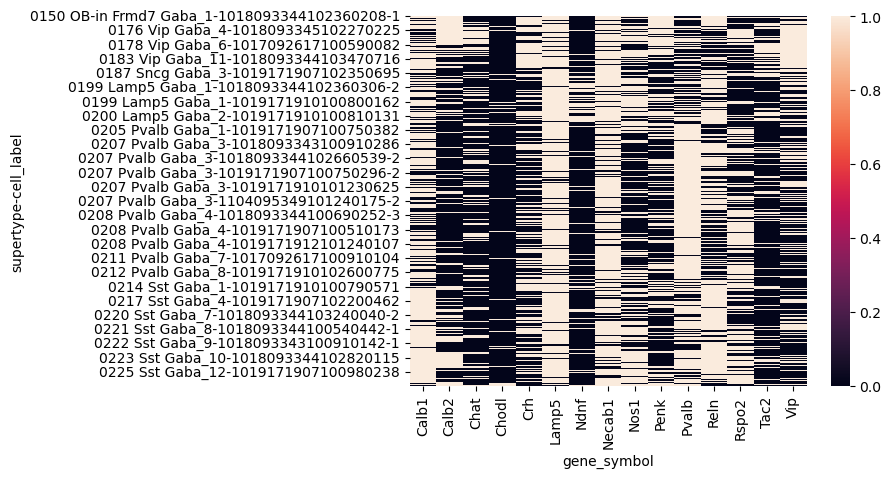

In [52]:
sns.heatmap(exp_pivot)

Hmm not sure what to do with this now

#### Quantify correlation in expression strength across cells 

Text(0.5, 1.0, 'correlated gene expression patterns')

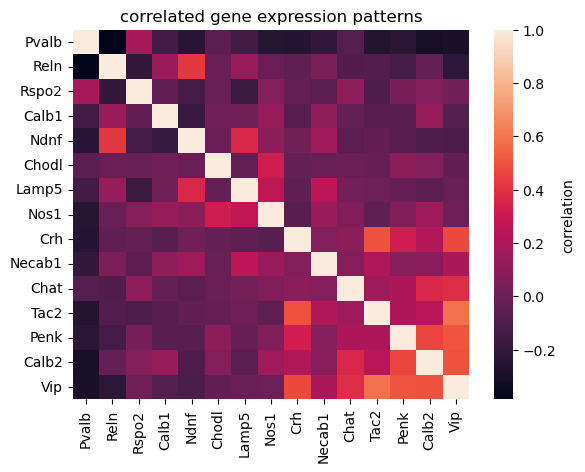

In [53]:
gene_names = selected_genes.gene_symbol.values

# correlate expression patterns across cells 
correlation_values = np.corrcoef(inh_gene_data, rowvar=False)
correlation_values = pd.DataFrame(data=correlation_values, columns=gene_names, index=gene_names)

# sort genes by avg correlation
order_mapping = dict(np.argsort(correlation_values.mean(axis=0)))
sorted_gene_names = gene_names[list(order_mapping.values())]
# sorted_gene_names

# # correlation_values = pd.DataFrame(data=correlation_values, columns=gene_names, index=gene_names)
correlation_values = correlation_values.loc[sorted_gene_names][sorted_gene_names]

fig, ax = plt.subplots()
ax = sns.heatmap(correlation_values, ax=ax, cbar_kws={'label':'correlation'})
ax.set_title('correlated gene expression patterns')

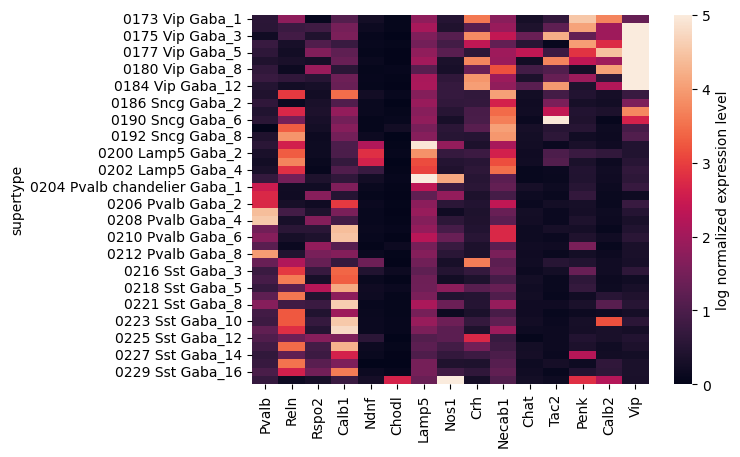

In [54]:
# Compare with average expression per supertype after sorting by mean correlation value
# Are the more correlated ones similarly expressed in specific cell types?
fig, ax = plt.subplots()
ax = sns.heatmap(avg_expression[sorted_gene_names], vmax=5, cbar_kws={'label':'log normalized expression level'}, )


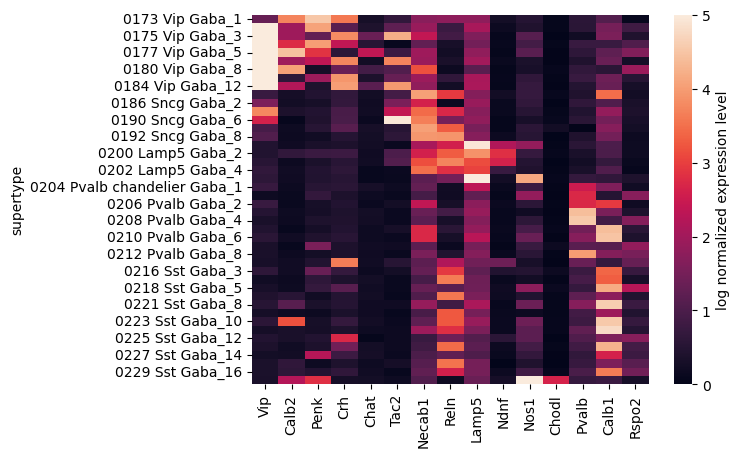

In [55]:
# Sort manually
sorted_genes = ['Vip', 'Calb2', 'Penk', 'Crh', 'Chat', 
                'Tac2', 'Necab1', 'Reln', 'Lamp5', 'Ndnf', 'Nos1', 'Chodl',
                'Pvalb', 'Calb1', 'Rspo2']
  
fig, ax = plt.subplots()
ax = sns.heatmap(avg_expression[sorted_genes], vmax=5, cbar_kws={'label':'log normalized expression level'}, )
